In [2]:
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 500)

In [3]:
book_cutoffs = "../booklist.csv"
cutoffs = pd.read_csv(book_cutoffs,index_col='asin')

In [4]:
dataset = "../test.json"
df = pd.read_json(dataset,lines=True)

In [5]:
# Peel out count of helpful votes into its own column
df['helpful_votes'] = df.apply(lambda x: x.helpful[0],axis=1)
# To avoid confusion later, drop the 'helpful' column at this point
df.drop('helpful', axis = 1, inplace=True)
# Convert reviewTime to datetime type info we can work with
df.reviewTime = pd.to_datetime(df.reviewTime,infer_datetime_format=True)

In [6]:
print("Our dataset initially contains {} reviews".format(df.shape[0]))

Our dataset initially contains 475978 reviews


In [7]:
# Our dataset snapshot has as its maximum review date 2014-07-23
snapshotted_string = "20140723"
snapshotted = datetime.datetime.strptime(snapshotted_string, '%Y%m%d')

# We will DROP reviews less than one year old
# They may not have accumulated enough evidence to support being helpful or not
ourcutoff = snapshotted - datetime.timedelta(days=365)
df = df[df.reviewTime < ourcutoff]
print("After removing reviews less than one year old, our dataset contains {} reviews".format(df.shape[0]))

After removing reviews less than one year old, our dataset contains 360680 reviews


In [8]:
# Here we store the age of each review in days
df['review_age_days'] = df.apply(lambda x: (snapshotted - x.reviewTime).days,axis = 1)

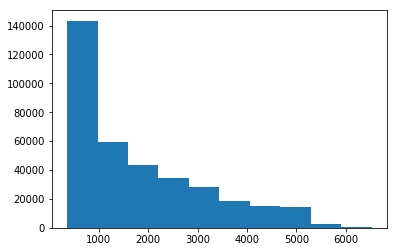

In [9]:
days_old_hist = plt.hist(df['review_age_days'])

In [10]:
# We create the annual HVAR score
df['annual_HVAR'] = df.apply(lambda x: 365*x.helpful_votes/x.review_age_days, axis = 1)

In [11]:
df.describe()

,overall,unixReviewTime,helpful_votes,review_age_days,annual_HVAR
count,360680.000000,3.606800e+05,360680.000000,360680.000000,360680.000000
mean,4.069926,1.251397e+09,6.704306,1790.239168,1.603826
std,1.209969,1.164771e+08,27.198241,1348.114480,6.830568
min,1.000000,8.430048e+08,0.000000,366.000000,0.000000
25%,3.000000,1.178842e+09,1.000000,653.000000,0.292468
50%,5.000000,1.291853e+09,2.000000,1322.000000,0.661232
75%,5.000000,1.349654e+09,5.000000,2630.000000,1.385725
max,5.000000,1.374451e+09,7136.000000,6517.000000,2088.724940


In [12]:
# Now we join the dev dataset and the by-book cutoff dataset
df = df.join(cutoffs,on='asin')

In [13]:
df.describe()

,overall,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR
count,360680.000000,3.606800e+05,360680.000000,360680.000000,360680.000000,313656.000000,313656.000000,313656.000000
mean,4.069926,1.251397e+09,6.704306,1790.239168,1.603826,75.411846,3.556318,1.539988
std,1.209969,1.164771e+08,27.198241,1348.114480,6.830568,195.637539,10.580872,1.877889
min,1.000000,8.430048e+08,0.000000,366.000000,0.000000,4.000000,0.000186,0.000000
25%,3.000000,1.178842e+09,1.000000,653.000000,0.292468,9.000000,0.722466,0.692892
50%,5.000000,1.291853e+09,2.000000,1322.000000,0.661232,22.000000,1.554675,1.042659
75%,5.000000,1.349654e+09,5.000000,2630.000000,1.385725,58.000000,3.454750,1.778518
max,5.000000,1.374451e+09,7136.000000,6517.000000,2088.724940,2472.000000,378.643335,113.758186


In [14]:
print(f"{df.book_num_reviews.isna().sum()} reviews in the test set get dropped for books having inadequate review counts/variance")

47024 reviews in the test set get dropped for books having inadequate review counts/variance


In [15]:
# We drop these here
df = df[df.book_num_reviews.notna()]
print(f"After removing off-limits books we have {df.shape[0]} dev reviews")

After removing off-limits books we have 313656 dev reviews


In [16]:
df.describe()

,overall,unixReviewTime,helpful_votes,review_age_days,annual_HVAR,book_num_reviews,std_HVAR,top_quartile_HVAR
count,313656.000000,3.136560e+05,313656.000000,313656.000000,313656.000000,313656.000000,313656.000000,313656.000000
mean,4.047546,1.250918e+09,6.887794,1795.780702,1.638184,75.411846,3.556318,1.539988
std,1.222164,1.162856e+08,28.876808,1345.897591,7.253470,195.637539,10.580872,1.877889
min,1.000000,8.430048e+08,0.000000,366.000000,0.000000,4.000000,0.000186,0.000000
25%,3.000000,1.178150e+09,1.000000,659.000000,0.285766,9.000000,0.722466,0.692892
50%,5.000000,1.290902e+09,2.000000,1333.000000,0.651786,22.000000,1.554675,1.042659
75%,5.000000,1.349136e+09,5.000000,2638.000000,1.367041,58.000000,3.454750,1.778518
max,5.000000,1.374451e+09,7136.000000,6517.000000,2088.724940,2472.000000,378.643335,113.758186


In [17]:
# Label reviews as most helpful if its annual_HVAR > top_quartile_HVAR
df['most_helpful'] = df.apply(lambda x: int(x.annual_HVAR > x.top_quartile_HVAR),axis = 1)

In [18]:
print(f"There are {df.shape[0]} reviews in our dev split")
print(f"{df.most_helpful.sum()/df.shape[0]:.2%} of reviews in the dev set carry the most_helpful label of 1")

There are 313656 reviews in our dev split
27.74% of reviews in the dev set carry the most_helpful label of 1


In [19]:
# Write it out to a file
df.to_csv('../labeled_test_set.csv',index=False)

In [20]:
!pwd

/home/jend/fp/RealRelevantReviews


In [21]:
!ls -lah ..

total 9.8G
drwxrwxr-x  4 jend jend 4.0K Jul 14 21:35 .
drwxr-xr-x 21 jend jend 4.0K Jul  3 02:22 ..
drwxrwxr-x  2 jend jend 4.0K Jul 13 23:56 .ipynb_checkpoints
drwxrwxr-x  4 jend jend 4.0K Jul 14 21:34 RealRelevantReviews
-rw-rw-r--  1 jend jend  15M Jul 13 23:56 book_cutoffs.csv
-rw-rw-r--  1 jend jend 9.6M Jul 14 21:01 booklist.csv
-rw-rw-r--  1 jend jend 585M Jul 14 19:08 dev.json
-rw-rw-r--  1 jend jend 391M Jul 14 21:26 labeled_dev_set.csv
-rw-rw-r--  1 jend jend 2.0M Jul 13 22:36 labeled_small_training_set.csv
-rw-rw-r--  1 jend jend 391M Jul 14 21:35 labeled_test_set.csv
-rw-rw-r--  1 jend jend 3.3G Jul 13 23:48 labeled_training_set.csv
-rw-rw-r--  1 jend jend 9.3M Jul  2 02:40 rowling.json
-rw-rw-r--  1 jend jend  47M Jun 22 04:41 small_train.json
-rw-rw-r--  1 jend jend 584M Jul 14 19:08 test.json
-rw-rw-r--  1 jend jend 467K Jun 22 04:37 toy_train.json
-rw-rw-r--  1 jend jend 4.6G Jul  3 02:23 train.json
